# Volatility Forecast Project

In this notebook, we intent to build a model to improve the forecast of volatility, which is an essential indicator for risk management in the Finance industry.

Please find the following table of contents to navigate this project. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Pre-Processing](#Pre-Processing)<br>
III. [Forecasting Model](#Forecasting-Model)<br>
IV. [Conclusion](#Conclusion)<br>
V. [Links](#Links)<br>


Let's get started by importing the necessary libraries and reading in the data.

In [1]:
# Uncomment only if necessary
#!pip install yfinance
#!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb


In [3]:
# We are going to work with major financial indices, from all over the world: (source: Yahoo Finance)
list_ticker = ['^GSPC', '^DJI', '^IXIC', '^NYA', '^XAX', '^RUT', '^FTSE', '^GDAXI', '^FCHI',
               '^N100', '^BFX', '^N225', '^HSI', '000001.SS', '399001.SZ', '^STI', '^AXJO',
               '^BSESN', '^JKSE', '^KLSE', '^KS11', '^TWII', '^GSPTSE', '^BVSP', '^MXX']

list_name = ['S&P 500', 'Dow Jones Industrial Average', 'NASDAQ Composite', 'NYSE COMPOSITE (DJ)',
             'NYSE AMEX COMPOSITE INDEX', 'Russell 2000', 'FTSE 100', 'DAX PERFORMANCE-INDEX', 'CAC 40',
             'Euronext 100 Index', 'BEL 20', 'Nikkei 225', 'HANG SENG INDEX', 'SSE Composite Index',
             'Shenzhen Index', 'STI Index', 'S&P/ASX 200', 'S&P BSE SENSEX', 'IDX COMPOSITE',
             'FTSE Bursa Malaysia KLCI', 'KOSPI Composite Index', 'TSEC weighted index',
             'S&P/TSX Composite index', 'IBOVESPA', 'IPC MEXICO']

dico_ticker_name = dict(zip(list_ticker, list_name))

ticker_request =''
for i in list_ticker:
    ticker_request = ticker_request +  i + " "
ticker_request

'^GSPC ^DJI ^IXIC ^NYA ^XAX ^RUT ^FTSE ^GDAXI ^FCHI ^N100 ^BFX ^N225 ^HSI 000001.SS 399001.SZ ^STI ^AXJO ^BSESN ^JKSE ^KLSE ^KS11 ^TWII ^GSPTSE ^BVSP ^MXX '

In [4]:
# Reading data and putting into a datafram
df = yf.download(ticker_request,
                 start="2000-01-01", end="2023-01-31",
                 group_by='ticker', interval='1d',
                 ignore_tz=True, auto_adjust = True)
df.head()

[*********************100%***********************]  25 of 25 completed


^AXJO                                                \
                   Open         High          Low        Close Volume   
Date                                                                    
2000-01-03          NaN          NaN          NaN          NaN    NaN   
2000-01-04  3093.699951  3093.699951  3093.699951  3093.699951    0.0   
2000-01-05  3018.699951  3018.699951  3018.699951  3018.699951    0.0   
2000-01-06  2999.300049  2999.300049  2999.300049  2999.300049    0.0   
2000-01-07  3023.399902  3023.399902  3023.399902  3023.399902    0.0   

                ^GSPTSE                                                     \
                   Open         High          Low        Close      Volume   
Date                                                                         
2000-01-03          NaN          NaN          NaN          NaN         NaN   
2000-01-04  8271.700195  8305.900391  8157.600098  8202.599609  59509800.0   
2000-01-05  8100.200195  8147.200195  8018.600098  8119.399902  94545700.0   
2000-01-06  8137.000000  8186.399902  8075.700195  8114.200195  79690100.0   
2000-01-07  8193.400391  8430.000000  8193.400391  8429.400391  87693100.0   

            ...        ^FCHI                                                \
            ...         Open         High          Low        Close Volume   
Date        ...                                                              
2000-01-03  ...  6024.379883  6102.120117  5901.770020  5917.370117    0.0   
2000-01-04  ...  5922.229980  5925.069824  5657.200195  5672.020020    0.0   
2000-01-05  ...  5521.830078  5589.500000  5461.589844  5479.700195    0.0   
2000-01-06  ...  5485.930176  5530.259766  5388.850098  5450.109863    0.0   
2000-01-07  ...  5423.879883  5561.689941  5423.879883  5539.609863    0.0   

                  ^TWII                                                
                   Open         High          Low        Close Volume  
Date                                                                   
2000-01-03          NaN          NaN          NaN          NaN    NaN  
2000-01-04  8644.878341  8803.577952  8642.468193  8756.517578    0.0  
2000-01-05  8690.567963  8867.647396  8667.987967  8849.837891    0.0  
2000-01-06  8900.526447  9023.956652  8833.877281  8921.997070    0.0  
2000-01-07  8853.397448  8940.736974  8739.397863  8849.837891    0.0  

[5 rows x 125 columns]

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

We explore the data to find insight into the descriptive statistics of the data.

What does the volatility look like over time ? Accross indices? This will help understand which machine learning model we should consider to forecast volatility.

In [5]:
# Rename columns with name instead of ticker for clarity
nb_col = df.shape[1]
for k in range(nb_col):
    try:
        df.rename(columns={df.columns[k][0]:dico_ticker_name[df.columns[k][0]]},inplace=True)
    except: 
        pass
df.columns

MultiIndex([(            'S&P/ASX 200',   'Open'),
            (            'S&P/ASX 200',   'High'),
            (            'S&P/ASX 200',    'Low'),
            (            'S&P/ASX 200',  'Close'),
            (            'S&P/ASX 200', 'Volume'),
            ('S&P/TSX Composite index',   'Open'),
            ('S&P/TSX Composite index',   'High'),
            ('S&P/TSX Composite index',    'Low'),
            ('S&P/TSX Composite index',  'Close'),
            ('S&P/TSX Composite index', 'Volume'),
            ...
            (                 'CAC 40',   'Open'),
            (                 'CAC 40',   'High'),
            (                 'CAC 40',    'Low'),
            (                 'CAC 40',  'Close'),
            (                 'CAC 40', 'Volume'),
            (    'TSEC weighted index',   'Open'),
            (    'TSEC weighted index',   'High'),
            (    'TSEC weighted index',    'Low'),
            (    'TSEC weighted index',  'Close'),
            (  

In [6]:
# Exploring the data further
df.describe()

S&P/ASX 200                                                       \
              Open         High          Low        Close        Volume   
count  5829.000000  5829.000000  5829.000000  5829.000000  5.829000e+03   
mean   4977.752926  5003.395181  4952.015148  4978.271402  3.792387e+07   
std    1241.958653  1247.977387  1235.796450  1241.995288  1.512740e+08   
min    2700.399902  2718.399902  2693.300049  2700.399902  0.000000e+00   
25%    4002.000000  4028.899902  3977.399902  4008.600098  0.000000e+00   
50%    5022.899902  5064.399902  4997.299805  5024.799805  0.000000e+00   
75%    5873.899902  5907.399902  5840.899902  5873.500000  0.000000e+00   
max    7629.000000  7632.799805  7585.899902  7628.899902  1.353735e+09   

      S&P/TSX Composite index                                            \
                         Open          High           Low         Close   
count             5797.000000   5797.000000   5797.000000   5797.000000   
mean             12855.357285  12918.923507  12781.240520  12852.688480   
std               3635.365296   3642.545499   3626.510315   3634.813536   
min               5689.399902   5812.899902   5678.299805   5695.299805   
25%              10030.200195  10117.900391   9939.200195  10027.400391   
50%              12835.400391  12901.400391  12758.599609  12826.500000   
75%              15203.900391  15258.000000  15136.799805  15202.400391   
max              22109.699219  22213.099609  22045.199219  22087.199219   

                     ...       CAC 40                                         \
             Volume  ...         Open         High          Low        Close   
count  5.797000e+03  ...  5900.000000  5900.000000  5900.000000  5900.000000   
mean   1.850226e+08  ...  4650.198222  4682.691158  4614.118226  4649.161966   
std    8.156888e+07  ...  1052.037873  1054.554634  1050.217986  1052.522611   
min    0.000000e+00  ...  2453.050049  2518.290039  2401.149902  2403.040039   
25%    1.334938e+08  ...  3780.785034  3806.277527  3753.105103  3781.334900   
50%    1.828437e+08  ...  4530.020020  4558.255127  4501.910156  4533.375000   
75%    2.259102e+08  ...  5413.199951  5442.155029  5383.887451  5415.350098   
max    9.440374e+08  ...  7320.479980  7384.859863  7313.529785  7376.370117   

                    TSEC weighted index                              \
             Volume                Open          High           Low   
count  5.900000e+03         5666.000000   5666.000000   5666.000000   
mean   9.113335e+07         8647.577291   8694.093949   8590.596830   
std    6.488305e+07         3103.200794   3113.389427   3091.931951   
min    0.000000e+00         3475.856776   3511.366699   3411.666836   
25%    5.663588e+07         6420.472961   6462.135421   6375.760746   
50%    9.241250e+07         8178.082958   8216.993790   8121.034326   
75%    1.294810e+08         9769.208264   9808.973620   9720.257581   
max    5.312476e+08        18598.130859  18619.609375  18446.519531   

                                   
              Close        Volume  
count   5666.000000  5.666000e+03  
mean    8640.836003  2.832301e+06  
std     3103.827472  1.834781e+06  
min     3446.247070  0.000000e+00  
25%     6418.740601  1.855325e+06  
50%     8169.404297  2.566150e+06  
75%     9763.077148  3.781975e+06  
max    18526.349609  1.499950e+07  

[8 rows x 125 columns]

In [7]:
# For easier manipulation we drop the MultiLevel of dataframe and give explicit names to columns
col_name = []
for tick,OHLC in df.columns:
    col_name.append(tick + ' ' + OHLC)

df.columns = col_name

In [8]:
cols_close = [x for x in df.columns if "Close" in x]

df_close = df[cols_close].copy()
df_close.head()


,S&P/ASX 200 Close,S&P/TSX Composite index Close,NYSE COMPOSITE (DJ) Close,FTSE Bursa Malaysia KLCI Close,Dow Jones Industrial Average Close,IBOVESPA Close,Russell 2000 Close,BEL 20 Close,HANG SENG INDEX Close,DAX PERFORMANCE-INDEX Close,...,Nikkei 225 Close,S&P BSE SENSEX Close,Euronext 100 Index Close,NASDAQ Composite Close,STI Index Close,FTSE 100 Close,S&P 500 Close,Shenzhen Index Close,CAC 40 Close,TSEC weighted index Close
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,6762.109863,833.890015,11357.509766,16930.0,496.420013,3311.050049,17369.630859,6750.759766,...,NaN,5375.109863,996.770020,4131.149902,2582.939941,NaN,1455.219971,NaN,5917.370117,NaN
2000-01-04,3093.699951,8202.599609,6543.759766,832.799988,10997.929688,15851.0,478.380005,3172.209961,17072.820312,6586.950195,...,19002.859375,5491.009766,955.969971,3901.689941,2530.149902,6665.899902,1399.420044,3497.020996,5672.020020,8756.517578
2000-01-05,3018.699951,8119.399902,6567.029785,815.799988,11122.650391,16245.0,478.829987,3057.530029,15846.719727,6502.069824,...,18542.550781,5357.000000,930.260010,3877.540039,2391.030029,6535.899902,1402.109985,3486.250977,5479.700195,8849.837891
2000-01-06,2999.300049,8114.200195,6635.439941,818.429993,11253.259766,16107.0,475.339996,3061.090088,15153.230469,6474.919922,...,18168.269531,5421.529785,922.460022,3727.129883,2359.209961,6447.200195,1403.449951,3655.158936,5450.109863,8921.997070
2000-01-07,3023.399902,8429.400391,6792.669922,NaN,11522.559570,16309.0,488.309998,3138.550049,15405.629883,6780.959961,...,18193.410156,5414.479980,943.880005,3882.620117,2406.040039,6504.799805,1441.469971,3827.997070,5539.609863,8849.837891


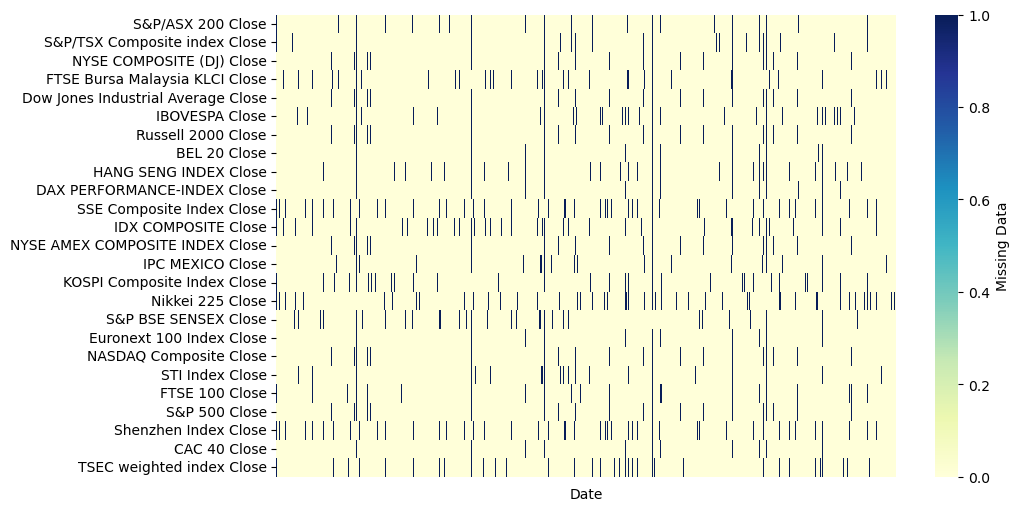

In [9]:
# Visualizing missing data (on the close, as this the most important feature)
plt.figure(figsize=(10,6))
sns.heatmap(df_close.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'}, xticklabels=False)
plt.show();

In [10]:
# We drop NaN because we need to calculate standard deviation of returns, so we dont want to bias the results
df.dropna(inplace=True)
df_close.dropna(inplace=True)
df.shape

(3907, 125)

For each ticker of our list we have 5 columns: Open, High, Low, Close and Volume.
We will now calculate the volatility - based on the Close price - for all the tickers

In [11]:
def price_return(price):
    '''
    INPUT:
    price - (pandas dataframe) dataframe columns of daily prices to calculate returns on
    
    OUTPUT:
    df_returns - (pandas dataframe) dataframe of daily price returns
    
    '''
    # calculate returns first
    df_returns = price.iloc[1:,:] / price.shift(1) - 1
    # remove first row which is NaN only
    df_returns = df_returns.iloc[1:,:]
    
    return df_returns

def volatility(df_returns, string_type='Close', horizon=60):
    '''
    INPUT:
    df_returns - (pandas dataframe) dataframe columns of daily returns to calculate volatility on
    string_type - (str) Low, High, Close or Open: specify the type for proper name of columns
    horizon - (int) number of days to use to measure volatility 
    
    OUTPUT:
    df_vol - (pandas dataframe) dataframe of volatility calculated for each columns of price on horizon days
    
    '''

    # calculate annualized volatility of returns
    df_vol = df_returns.rolling(horizon).std() * np.sqrt(252)
    
    # rename columns
    df_vol.columns = df_vol.columns.str.replace(string_type, string_type + ' Volatility')
    
    df_vol = df_vol.iloc[horizon:,:]
    
    return df_vol    

In [12]:
df_returns_close = price_return(df_close)
df_returns_close.describe()

,S&P/ASX 200 Close,S&P/TSX Composite index Close,NYSE COMPOSITE (DJ) Close,FTSE Bursa Malaysia KLCI Close,Dow Jones Industrial Average Close,IBOVESPA Close,Russell 2000 Close,BEL 20 Close,HANG SENG INDEX Close,DAX PERFORMANCE-INDEX Close,...,Nikkei 225 Close,S&P BSE SENSEX Close,Euronext 100 Index Close,NASDAQ Composite Close,STI Index Close,FTSE 100 Close,S&P 500 Close,Shenzhen Index Close,CAC 40 Close,TSEC weighted index Close
count,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,...,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000
mean,0.000298,0.000325,0.000330,0.000204,0.000382,0.000729,0.000517,0.000169,0.000219,0.000371,...,0.000244,0.000763,0.000209,0.000446,0.000172,0.000140,0.000373,0.000538,0.000204,0.000280
std,0.011982,0.013273,0.014370,0.010319,0.013742,0.021266,0.018092,0.015370,0.017497,0.017726,...,0.017224,0.017499,0.015774,0.018486,0.014026,0.014104,0.014320,0.021001,0.017117,0.016328
min,-0.146649,-0.226677,-0.185497,-0.126050,-0.180329,-0.259334,-0.225149,-0.213703,-0.136666,-0.206270,...,-0.160836,-0.127699,-0.206983,-0.160201,-0.150245,-0.189568,-0.165434,-0.117781,-0.213043,-0.119951
25%,-0.005106,-0.004917,-0.005477,-0.003934,-0.005428,-0.010246,-0.008179,-0.006008,-0.007772,-0.007584,...,-0.007915,-0.007063,-0.006603,-0.007575,-0.005437,-0.006044,-0.005557,-0.009293,-0.007326,-0.006519
50%,0.000784,0.000754,0.000790,0.000288,0.000704,0.000776,0.000933,0.000409,0.000537,0.000954,...,0.000540,0.000987,0.000816,0.001070,0.000284,0.000591,0.000768,0.000281,0.000742,0.000659
75%,0.006184,0.006183,0.006548,0.004753,0.006367,0.012256,0.009718,0.007305,0.008347,0.008680,...,0.009043,0.008810,0.007492,0.008810,0.005937,0.006791,0.006685,0.010130,0.008195,0.007745
max,0.079735,0.119571,0.100365,0.071485,0.113650,0.138070,0.111295,0.105692,0.182945,0.128128,...,0.105010,0.174857,0.101227,0.136730,0.239542,0.103227,0.098569,0.142495,0.113943,0.174413


In [13]:
# Calculate the volatility for each ticker as a time serie
df_volatility = volatility(df_returns_close)
df_volatility.tail(3)

,S&P/ASX 200 Close Volatility,S&P/TSX Composite index Close Volatility,NYSE COMPOSITE (DJ) Close Volatility,FTSE Bursa Malaysia KLCI Close Volatility,Dow Jones Industrial Average Close Volatility,IBOVESPA Close Volatility,Russell 2000 Close Volatility,BEL 20 Close Volatility,HANG SENG INDEX Close Volatility,DAX PERFORMANCE-INDEX Close Volatility,...,Nikkei 225 Close Volatility,S&P BSE SENSEX Close Volatility,Euronext 100 Index Close Volatility,NASDAQ Composite Close Volatility,STI Index Close Volatility,FTSE 100 Close Volatility,S&P 500 Close Volatility,Shenzhen Index Close Volatility,CAC 40 Close Volatility,TSEC weighted index Close Volatility
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-13,0.187141,0.191207,0.233671,0.134222,0.223269,0.278219,0.315690,0.184975,0.406235,0.204253,...,0.204778,0.146481,0.189464,0.342915,0.136242,0.136648,0.268814,0.240481,0.205400,0.241911
2023-01-17,0.181859,0.189988,0.232742,0.133994,0.219977,0.277849,0.315180,0.184916,0.404046,0.200419,...,0.200237,0.143926,0.187237,0.340799,0.131751,0.132660,0.266096,0.241070,0.202573,0.238414
2023-01-30,0.174691,0.190125,0.232998,0.131141,0.220476,0.277907,0.315114,0.191694,0.402250,0.198559,...,0.218603,0.148988,0.187542,0.345070,0.143670,0.130072,0.266343,0.245108,0.202226,0.248033


In [14]:
df_volatility.describe()

,S&P/ASX 200 Close Volatility,S&P/TSX Composite index Close Volatility,NYSE COMPOSITE (DJ) Close Volatility,FTSE Bursa Malaysia KLCI Close Volatility,Dow Jones Industrial Average Close Volatility,IBOVESPA Close Volatility,Russell 2000 Close Volatility,BEL 20 Close Volatility,HANG SENG INDEX Close Volatility,DAX PERFORMANCE-INDEX Close Volatility,...,Nikkei 225 Close Volatility,S&P BSE SENSEX Close Volatility,Euronext 100 Index Close Volatility,NASDAQ Composite Close Volatility,STI Index Close Volatility,FTSE 100 Close Volatility,S&P 500 Close Volatility,Shenzhen Index Close Volatility,CAC 40 Close Volatility,TSEC weighted index Close Volatility
count,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,...,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000,3846.000000
mean,0.172060,0.179046,0.200406,0.146082,0.193584,0.314990,0.262737,0.218101,0.251796,0.253515,...,0.258598,0.250618,0.225780,0.259059,0.195436,0.201094,0.201755,0.309616,0.246111,0.235468
std,0.080868,0.107670,0.109695,0.067924,0.100548,0.122434,0.115710,0.109373,0.109776,0.122432,...,0.090728,0.116371,0.110071,0.130420,0.104430,0.100616,0.104276,0.120362,0.116138,0.105014
min,0.068953,0.052434,0.057365,0.044378,0.064519,0.138016,0.105925,0.082194,0.107503,0.096951,...,0.107683,0.093162,0.081069,0.076664,0.061575,0.080572,0.061842,0.132330,0.088907,0.091788
25%,0.121111,0.114511,0.135487,0.096230,0.131630,0.244626,0.192279,0.142054,0.181885,0.170596,...,0.201450,0.173160,0.150373,0.169885,0.123122,0.134695,0.136875,0.226074,0.164655,0.153326
50%,0.153984,0.148746,0.170653,0.129315,0.163078,0.280857,0.234218,0.186915,0.223297,0.219732,...,0.247691,0.214143,0.195293,0.213654,0.165519,0.171991,0.169985,0.283247,0.215897,0.207884
75%,0.194405,0.202073,0.233671,0.172428,0.228988,0.360377,0.298609,0.255667,0.289004,0.283664,...,0.299221,0.284408,0.259474,0.313518,0.231837,0.239059,0.246674,0.348434,0.283139,0.297695
max,0.536741,0.665505,0.724673,0.353747,0.657998,0.945029,0.800391,0.662128,0.751810,0.686560,...,0.707846,0.680934,0.670532,0.686032,0.661138,0.672868,0.666009,0.785564,0.702459,0.554248


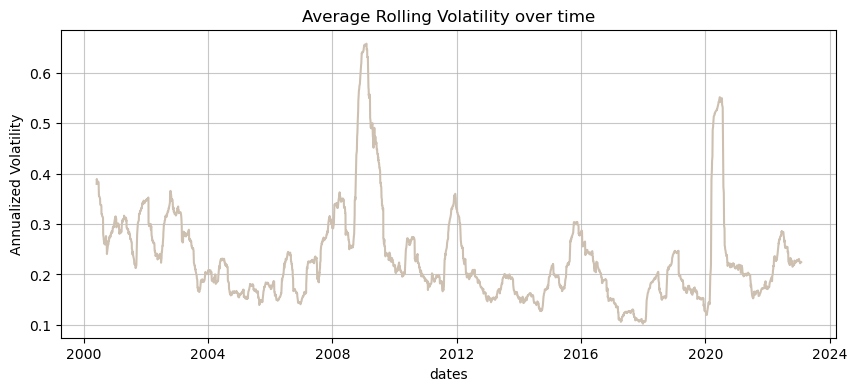

In [15]:
# Plot Timeserie of Volatilities
color_box = '#CDC0B0'
figure = plt.figure(figsize = (10, 4))
l1, = plt.plot(df_volatility.mean(axis=1));
plt.xlabel('dates');
plt.ylabel('Annualized Volatility');
plt.title('Average Rolling Volatility over time');
plt.grid(True, linestyle="-", alpha=0.7)
l1.set_color(color_box)
plt.show();

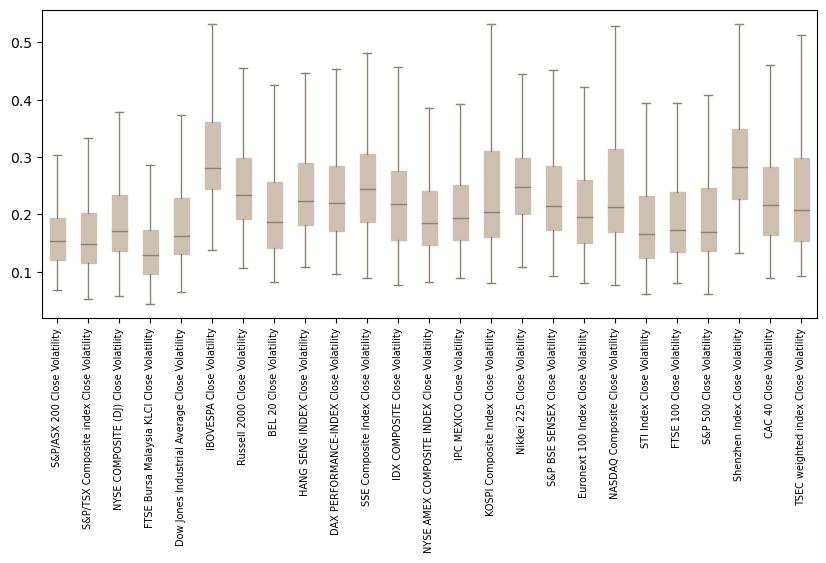

In [16]:
# Plot Cross Sectional Volatility
figure = plt.figure(figsize = (10, 4))  
ax = figure.add_subplot(111)
bp = ax.boxplot(df_volatility,sym='',patch_artist = True, labels=df_volatility.columns)

#plt.boxplot(df_vol,sym='',patch_artist = True, labels=df_vol.columns)
plt.xticks(rotation=90, fontsize=7)

# Some formatting
color_box = '#CDC0B0'
color_other = '#8B8378'

for median in bp['medians']:  
    median.set(color=color_other)  
    
for patch in bp['boxes']:  
    patch.set_facecolor(color_box)
    patch.set_edgecolor(color_box)
    
for cap in bp['caps']:  
    cap.set(color=color_other)  

for flier in bp['fliers']:  
    flier.set(marker='D',color =color_other)       

for whisker in bp['whiskers']:
    whisker.set(color=color_other)  
    
plt.show();

### <a class="anchor" id="Pre-Processing">Part II : Pre-Processing</a>

We know format the process the data to be able to use it in a model.

In [17]:
# We need to normalize the data to be able to forecast volatility independantly of the absolute level of a price.
# We decide to use the returns instead of the price. For volumes, which might be an interesting feature for forecast,

cols_open = [x for x in df.columns if "Open" in x]
df_open = df[cols_open].copy()

cols_high = [x for x in df.columns if "High" in x]
df_high = df[cols_high].copy()

cols_low = [x for x in df.columns if "Low" in x]
df_low = df[cols_low].copy()

cols_volume = [x for x in df.columns if "Volume" in x]
df_volume = df[cols_volume].copy()


In [18]:
# Returns of each category
df_returns_open = price_return(df_open)
df_returns_high = price_return(df_high)
df_returns_low = price_return(df_low)

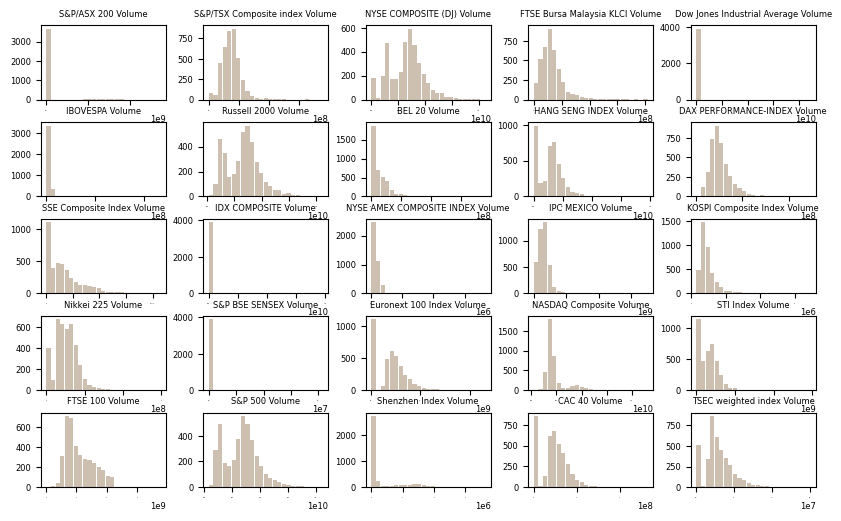

In [19]:
# We check the distribution of volumes as well as time serie to assess what is the best way to use it
params = {'axes.titlesize':'6',
          'xtick.labelsize':'6',
          'ytick.labelsize':'6'}
matplotlib.rcParams.update(params)
ax = df_volume.hist(xlabelsize = 0,
                    bins=25,
                    grid=False, figsize=(10,6), color=color_box, zorder=0, rwidth=0.9)

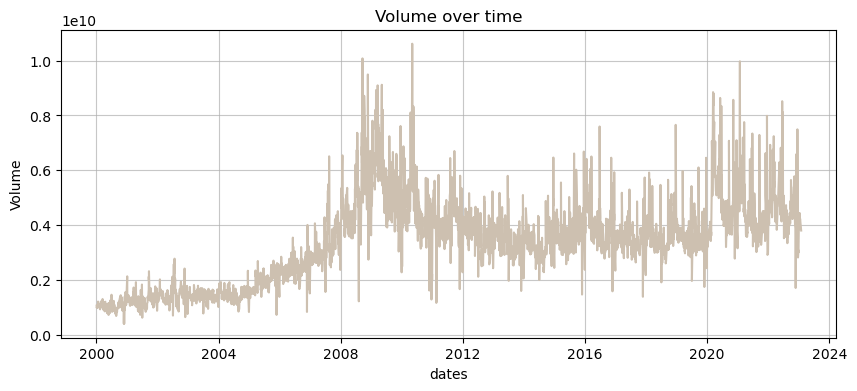

In [20]:
# Checking Time serie visually for one ticker:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
color_box = '#CDC0B0'
figure = plt.figure(figsize = (10, 4))
l1, = plt.plot(df_volume['S&P 500 Volume']);

plt.xlabel('dates');
plt.ylabel('Volume');
plt.title('Volume over time');
plt.grid(True, linestyle="-", alpha=0.7)
l1.set_color(color_box)
plt.show();

Considering the noise on the data we use a moving average to smooth it. And we wwant to keep its distribution characterics so we use a zscore


In [21]:
def normalize_volume(df, MA_length=20, avg_forced=None, std_forced=None):
    '''
    INPUT:
    df - (pandas dataframe) dataframe columns to be transformed into z-score
    MA_length - (int) moving average length. Default at 20 days
    avg_forced - (array) only input to force the average, otherwise it is computed.
    std_forced - (array) only input to force the standard deviation, otherwise it is computed.
    
    OUTPUT:
    df_returns - (pandas dataframe) dataframe of daily price returns
    
    NOTE:
    forced parameters will be used for the validation sets, as we don't want to use future data in the calculation of zscore
    '''
    # First calculate moving average
    df_MA = df.rolling(MA_length).mean()
    df_MA.dropna(inplace=True)
    
    if avg_forced == None:
        df_avg = df_MA.mean(axis=0)
    else:
        df_avg = avg_forced
    
    if std_forced == None:
        df_std = df_MA.std(axis=0)
    else:
        df_std = std_forced
    
    # calculate zscore on top of moving average
    df_zscore = (df_MA - df_avg) / df_std
    
    return df_zscore

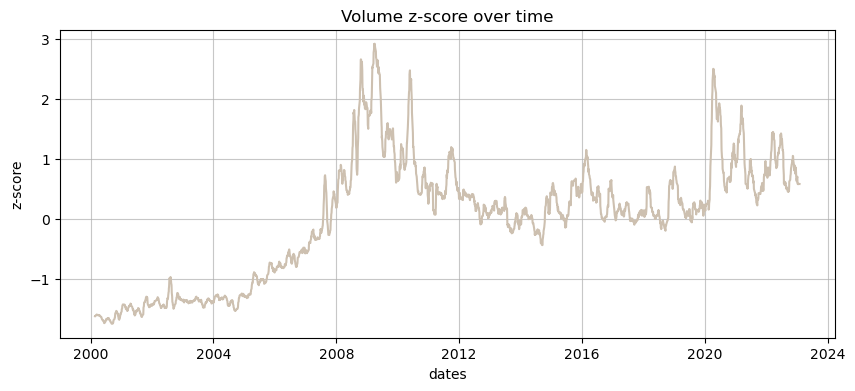

In [22]:
volume_normalized = normalize_volume(df_volume)

# Checking visually for one ticker:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
color_box = '#CDC0B0'
figure = plt.figure(figsize = (10, 4))
l1, = plt.plot(volume_normalized['S&P 500 Volume']);
plt.xlabel('dates');
plt.ylabel('z-score');
plt.title('Volume z-score over time');
plt.grid(True, linestyle="-", alpha=0.7)
l1.set_color(color_box)
plt.show();

In [23]:
# We create new features to improve our forecasting probabilities

def add_features_returns(df_returns, list_name, string_type):
    '''
    INPUT:
    df_returns - (pandas dataframe) dataframe columns of returns
    list_name - (array) list of ticker_name for which we add features
    string_type - (string) Close, Open, High or Low
    
    OUTPUT:
    df_with_features - (pandas dataframe) dataframe with added features
    
    NOTE:
    New features are:
     - last week volatility,
     - last month volatility,
     - last week return
     - last month return
     - D-1 return
     - D-2 return
     - D-3 return
     - D-4 return
     '''
    
    df_with_features = df_returns.copy()
    # creating new features
    df_vol1w = volatility(df_returns, string_type).shift(5)
    # 1 month is 22 working days on average
    df_vol1m = volatility(df_returns, string_type).shift(22)
    df_ret1w = df_returns.shift(5)
    df_ret1m = df_returns.shift(22)
    df_ret1d = df_returns.shift(1)
    df_ret2d = df_returns.shift(2)
    df_ret3d = df_returns.shift(3)
    df_ret4d = df_returns.shift(4)
    
    for ticker_name in list_name:
        df_with_features[ticker_name + ' ' + string_type + ' volatility_1w'] = \
                                df_vol1w[ticker_name + ' ' + string_type + ' Volatility']
        df_with_features[ticker_name + ' ' + string_type + ' volatility_1m'] = \
                                df_vol1m[ticker_name + ' ' + string_type + ' Volatility']
            
        df_with_features[ticker_name + ' ' + string_type + ' return_1w'] = df_ret1w[ticker_name + ' ' + string_type]
        df_with_features[ticker_name + ' ' + string_type + ' return_1m'] = df_ret1m[ticker_name + ' ' + string_type]
        df_with_features[ticker_name + ' ' + string_type + ' return_1d'] = df_ret1d[ticker_name + ' ' + string_type]
        df_with_features[ticker_name + ' ' + string_type + ' return_2d'] = df_ret2d[ticker_name + ' ' + string_type]
        df_with_features[ticker_name + ' ' + string_type + ' return_3d'] = df_ret3d[ticker_name + ' ' + string_type]
        df_with_features[ticker_name + ' ' + string_type + ' return_4d'] = df_ret4d[ticker_name + ' ' + string_type]
        
    return df_with_features


def add_features_volume(df_volume, list_name):
    '''
    INPUT:
    df_volume - (pandas dataframe) dataframe columns of normalized volumes
    list_name - (array) list of ticker_name for which we add features
    
    OUTPUT:
    df_with_features - (pandas dataframe) dataframe with added features
    
    NOTE:
    New features are:
     - 1 week change of volume
     - 1 month change of volume
    '''
    
    df_with_features = df_volume.copy()
    
    for ticker_name in list_name:
        df_with_features[ticker_name + ' volume_chg1w'] = df_volume[ticker_name + ' Volume'] - \
                                                          df_volume[ticker_name + ' Volume'].shift(5)
        # 1 month is 22 working days on average
        df_with_features[ticker_name + ' volume_chg1m'] = df_volume[ticker_name + ' Volume'] - \
                                                          df_volume[ticker_name + ' Volume'].shift(22)
        
    return df_with_features

In [24]:
# Check shapes to drop necessary rows
(df_returns_open.shape, df_returns_high.shape, df_returns_low.shape, df_returns_close.shape, volume_normalized.shape)

((3906, 25), (3906, 25), (3906, 25), (3906, 25), (3888, 25))

In [25]:
df_returns_open = df_returns_open.iloc[18:,:]
df_returns_high = df_returns_high.iloc[18:,:]
df_returns_low = df_returns_low.iloc[18:,:]
df_returns_close  = df_returns_close.iloc[18:,:]
(df_returns_open.shape, df_returns_high.shape, df_returns_low.shape, df_returns_close.shape, volume_normalized.shape)

((3888, 25), (3888, 25), (3888, 25), (3888, 25), (3888, 25))

In [26]:
# Putting all together for forecasting.

# Input for model
X_open = add_features_returns(df_returns_open, list_name, 'Open')
X_close = add_features_returns(df_returns_close, list_name, 'Close')
X_high = add_features_returns(df_returns_high, list_name, 'High')
X_low = add_features_returns(df_returns_low, list_name, 'Low')
X_volume = add_features_volume(volume_normalized, list_name)

X = pd.concat([X_open,X_close,X_high,X_low, X_volume],axis=1)
# We need to drop the first (60+22) rows used to calculate volatility 1 month feature
horizon_volatility = 60
nb_days_per_month = 22
X = X.iloc[horizon_volatility + nb_days_per_month:,:]

X.shape


C:\Users\barka\AppData\Local\Temp\ipykernel_21376\1939591141.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_features[ticker_name + ' ' + string_type + ' return_1m'] = df_ret1m[ticker_name + ' ' + string_type]
C:\Users\barka\AppData\Local\Temp\ipykernel_21376\1939591141.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_features[ticker_name + ' ' + string_type + ' return_1d'] = df_ret1d[ticker_name + ' ' + string_type]
C:\Users\barka\AppData\Local\Temp\ipykernel_21376\1939591141.py:46: PerformanceWarning: 

C:\Users\barka\AppData\Local\Temp\ipykernel_21376\1939591141.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_features[ticker_name + ' ' + string_type + ' return_4d'] = df_ret4d[ticker_name + ' ' + string_type]
C:\Users\barka\AppData\Local\Temp\ipykernel_21376\1939591141.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_features[ticker_name + ' ' + string_type + ' volatility_1w'] = \
C:\Users\barka\AppData\Local\Temp\ipykernel_21376\1939591141.py:40: PerformanceWarning: DataFrame is highly fragmented.  Thi

(3806, 975)

In [27]:
# Output for model
y = df_volatility
y.shape

(3846, 25)

In [28]:
# We harmonize size of X and y by droping the first rows of y
y = y.iloc[y.shape[0]-X.shape[0]:,:]

In [29]:
# We need a function to select a single ticker for training and fitting our algorithm
def get_data_ticker(df, ticker):
    '''
    INPUT:
    df - (pandas dataframe) dataframe with features for algorithms
    ticker - (string) ticker name to extract features for.
    
    OUTPUT:
    df_ticker - (pandas dataframe) dataframe of all the features for the ticker.
    
    '''
    col_ticker=[]
    
    for col_name in df.columns:
        if ticker in col_name:
            col_ticker.append(col_name) 
    
    df_ticker = df[col_ticker].copy()
       
    return df_ticker

In [30]:
ticker='Russell 2000'

In [31]:
X_ticker = get_data_ticker(X, ticker)
y_ticker = get_data_ticker(y, ticker)

X_ticker.shape,y_ticker.shape

((3806, 39), (3806, 1))

In [32]:
# We now split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_ticker, y_ticker, test_size=0.2, random_state=123)

In [33]:
X_train.shape,X_test.shape

((3044, 39), (762, 39))

In [34]:
# Processing to use XGBoost library
data_dmatrix = xgb.DMatrix(data=X_ticker,label=y_ticker)

dtrain = xgb.DMatrix(data=X_train,label=y_train)
dtest = xgb.DMatrix(data=X_test,label=y_test)

### <a class="anchor" id="Forecasting-Model">Part III : Forecasting Models</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

In [35]:
#initiate regressor. Searching for best parameter for n_estimators
estimator_array = []
rmse_array = []

for n_esti in range(2,200,5):
    estimator_array.append(n_esti)
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = n_esti)
    xg_reg.fit(X_train,y_train)
    preds = xg_reg.predict(X_test)
    rmse_array.append(np.sqrt(mean_squared_error(y_test, preds)))

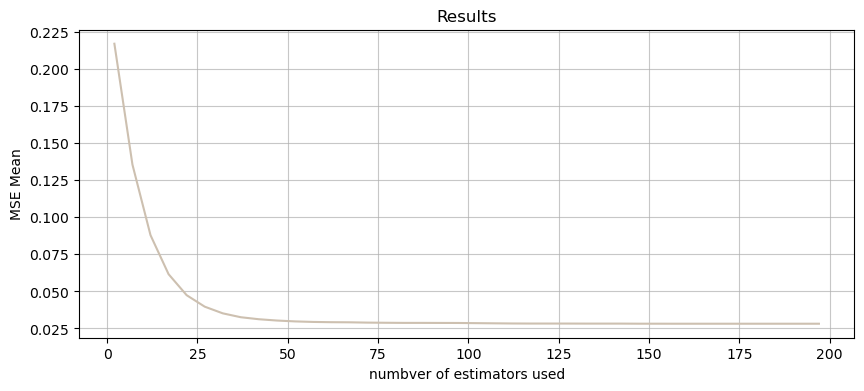

In [36]:
# Checking results visually:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
color_box = '#CDC0B0'
figure = plt.figure(figsize = (10, 4))
l1, = plt.plot(estimator_array, rmse_array);

plt.xlabel('numbver of estimators used');
plt.ylabel('MSE Mean');
plt.title('Results');
plt.grid(True, linestyle="-", alpha=0.7)
l1.set_color(color_box)

plt.show();

n_estimators at 50 is enough convergence

In [37]:
# Below is the model we are using going forward, using our optimal n_estimators
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 50)
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [38]:
# We measure the forecasting error
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.029981


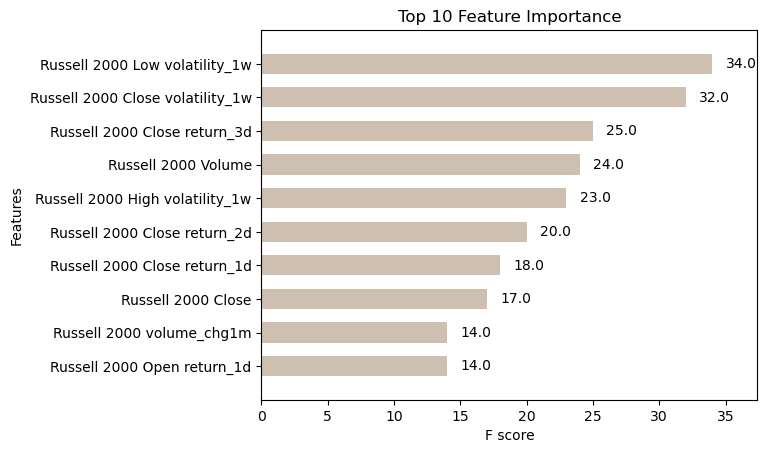

In [39]:
# Display importance of each feature column in the dataset within the model
xgb.plot_importance(xg_reg, height=0.6, grid=False, max_num_features=10, color=color_box, title='Top 10 Feature Importance')
plt.show()

In [40]:
# 3-fold cross validation model using XGBoost
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [41]:
# Final boosting round
print((cv_results["test-rmse-mean"]).tail(1))

49    0.035278
Name: test-rmse-mean, dtype: float64


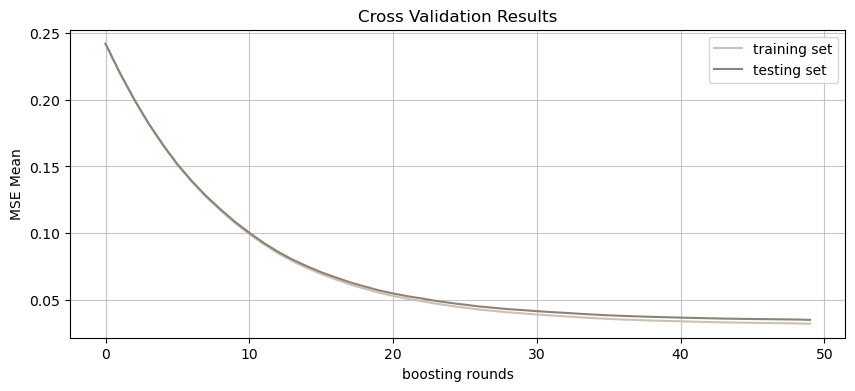

In [42]:
# Checking cv results visually:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
color_box = '#CDC0B0'
figure = plt.figure(figsize = (10, 4))
l1, = plt.plot(cv_results['train-rmse-mean'], label='training set');
l2, = plt.plot(cv_results['test-rmse-mean'], label='testing set');

plt.xlabel('boosting rounds');
plt.ylabel('MSE Mean');
plt.title('Cross Validation Results');

plt.grid(True, linestyle="-", alpha=0.7)
l1.set_color(color_box)
l2.set_color(color_other)
plt.legend()
plt.show();


- We now train our model on all tickers in a loop, and see if we can improve forecasting.
- Also we want to know which index is easier to forecast, as it will have consequence on our investment universe.

In [43]:
# Loop on all tickers to train our model and check results

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 50)

#initialize result: error of forecasting
rmse_ticker = pd.DataFrame(list_name, columns=['Ticker'])
rmse_ticker['RMSE'] = 0

tick_num = 0
for ticker in list_name:
    X_ticker = get_data_ticker(X, ticker)
    y_ticker = get_data_ticker(y, ticker)
    
    # We now split the data into training set and testing set
    X_train, X_test, y_train, y_test = train_test_split(X_ticker, y_ticker, test_size=0.2, random_state=123)
    
    # Processing to use XGBoost library
    data_dmatrix = xgb.DMatrix(data=X_ticker,label=y_ticker)
    
    xg_reg.fit(X_train,y_train)

    preds = xg_reg.predict(X_test)
    rmse_ticker.loc[tick_num, 'RMSE'] = np.sqrt(mean_squared_error(y_test, preds))
    
    tick_num +=1

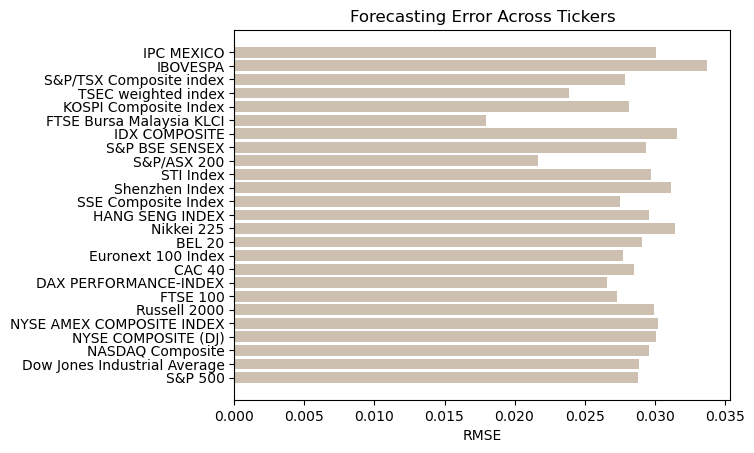

<Figure size 1000x400 with 0 Axes>

In [44]:
# Checking cv results visually:
plt.rcdefaults()
fig, ax = plt.subplots()
color_box = '#CDC0B0'
figure = plt.figure(figsize = (10, 4))
ax.barh(rmse_ticker['Ticker'], rmse_ticker['RMSE'], align='center', color=color_box)
ax.set_xlabel('RMSE')
ax.set_title('Forecasting Error Across Tickers')

plt.show();

### <a class="anchor" id="Conclusion">Part IV : Conclusion</a>

- We have built a solid model to forecast volatility of indices using as inputs prices and volumes only, which are easily available data.
- We have reached very low levels of error (2%-3%, considering volatility is in the 20-30% area most of the time)
- We have seen that the most important features to forecast current volatility are past volatility, which makes sense fundamentally: volatlity is calculated using a window of returns. So most of this information is already contained in past volatility.
- We have seen that forecasting power is consistant across indices, which gives us confidence that we can deploy this model for major indices in the Equity Market.

### <a class="anchor" id="Links">Part V : Links</a>

All this project is summarized in a blog that we hope you will enjoy !

Medium Post:
[Smarter Risk Management: Forecasting Volatility with Machine Learning](https://medium.com/@barkate.jerome/smarter-risk-management-forecasting-volatility-with-machine-learning-b71d41293e6e)

Github:
[Link to corresponding Github](https://github.com/jek1705/Capstone_Project_Volatility)
